In [ ]:
%autosave 200

## Imports

In [1]:
import sys
import random
import numpy as np
import pandas as pd
import cv2
import csv
import os
import win32com.client
import win32gui
import win32con
import win32api
import pyvjoy
import pyautogui
import pygame
import matplotlib.pyplot as plt
import pygetwindow as gw
import asyncio
import threading
from time import time, sleep
from pygame.locals import JOYAXISMOTION, QUIT
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, Dict, Any
from directinputs import PressKey, ReleaseKey, CTRL, eight, nine
from sim_info_acti import SimInfo
from gym import Env, spaces
from gym.spaces import Box, Discrete
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.policies import ActorCriticPolicy


pygame 2.1.0 (SDL 2.0.16, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Taking screenshot 

In [2]:
def TakeScreenshot(window_title=None):  
    shell = win32com.client.Dispatch("WScript.Shell")
    shell.SendKeys('%') 
    if window_title:
        hwnd = win32gui.FindWindow(None, window_title)
        if hwnd:
            win32gui.SetForegroundWindow(hwnd)  
            x, y, x1, y1 = win32gui.GetClientRect(hwnd)
            x, y = win32gui.ClientToScreen(hwnd, (x, y))
            x1, y1 = win32gui.ClientToScreen(hwnd, (x1 - x, y1 - y))
            win32gui.SetForegroundWindow(hwnd) 
            frame = np.array(pyautogui.screenshot(region=(x, y, x1, y1)))
            resize = cv2.resize(frame,(128,72), interpolation=cv2.INTER_CUBIC)
            grayscale_image = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
            image = np.expand_dims(grayscale_image, axis=-1)
            cv2.imshow('image', image)
            cv2.moveWindow('image',2000, 400)
            cv2.waitKey(1)
            return image
        else:
            print('Az ablak nem található!')
    else:
        frame = np.array(pyautogui.screenshot(), dtype=object)
        resize = cv2.resize(frame,(1280,720), interpolation=cv2.INTER_CUBIC)
        grayscale_image = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
        return grayscale_image


## packing telemetry data and screenshot

In [3]:
class DataCollector():
    def __init__(self, window, async_sample=False):
        self.window = window
        self.running = True
        
        self.frame = np.zeros((72, 128, 3))
        self.speed, self.onTrack, self.wheelSlipRL, self.wheelSlipRR, self.gear, self.rpm, self.steerAngle, self.carDamagefront, self.carDamagerear, self.carDamageleft, self.carDamageright, self.carDamagecentre, self.distanceTraveled, self.currentSectorIndex, self.completedLaps, self.gas, self.brake, self.carCoordinatesX, self.carCoordinatesY, self.carCoordinatesZ, self.maxRpm = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0,0, 0]

        self.telemetry = SimInfo()
        self.async_sample= async_sample
        
        self.pause = False
        
        if self.async_sample:
            self._sample_thread = Thread(
                target=self.sample_data, args=())
            self._sample_thread.daemon = True
            self._sample_thread.start()
            
            
    def __del__(self):
        self.stop()

    def stop(self):
        self.running = False
         
    def resume(self):
        self.pause = False
        

    def pause(self):
        self.pause = True
        print('Az adatgyűjtés megállt')    
    
 
    def return_data(self):       
            return [
                
                self.speed,
                self.onTrack,
                self.wheelSlipRL,
                self.wheelSlipRR,
                self.gear,
                self.rpm,
                self.steerAngle,
                self.carDamagefront,
                self.carDamagerear,
                self.carDamageleft,
                self.carDamageright,
                self.carDamagecentre,
                self.distanceTraveled,
                self.currentSectorIndex,
                self.completedLaps,
                self.gas,
                self.brake,
                self.carCoordinatesX,
                self.carCoordinatesY,
                self.carCoordinatesZ,
                self.maxRpm,
                self.frame]    
        
    def sample(self):
        while self.running:
            self.speed, self.onTrack, self.wheelSlipRL, self.wheelSlipRR, self.gear, self.rpm, self.steerAngle, self.carDamagefront, self.carDamagerear, self.carDamageleft, self.carDamageright, self.carDamagecentre, self.distanceTraveled, self.currentSectorIndex, self.completedLaps, self.gas, self.brake, self.carCoordinatesX, self.carCoordinatesY, self.carCoordinatesZ,self.maxRpm, self.frame = self.telemetry.physics.speedKmh, self.telemetry.physics.numberOfTyresOut, list(self.telemetry.physics.wheelSlip)[2], list(self.telemetry.physics.wheelSlip)[3], self.telemetry.physics.gear, self.telemetry.physics.rpms, self.telemetry.physics.steerAngle, list(self.telemetry.physics.carDamage)[0], list(self.telemetry.physics.carDamage)[1], list(self.telemetry.physics.carDamage)[2], list(self.telemetry.physics.carDamage)[3], list(self.telemetry.physics.carDamage)[4], self.telemetry.graphics.distanceTraveled, self.telemetry.graphics.currentSectorIndex, self.telemetry.graphics.completedLaps, self.telemetry.physics.gas, self.telemetry.physics.brake, list(self.telemetry.graphics.carCoordinates)[0], list(self.telemetry.graphics.carCoordinates)[1], list(self.telemetry.graphics.carCoordinates)[2], self.telemetry.static.maxRpm, np.array(TakeScreenshot(self.window)) 
            
            data_samples = self.return_data()
            
            if self.async_sample == False:
                break

        return data_samples


In [4]:


class LogitechG29Data(object):
    pygame.init()
    pygame.joystick.init()
    joysticks = [pygame.joystick.Joystick(i) for i in range(pygame.joystick.get_count())]
    print(joysticks)
    for joystick in joysticks:
        print(f"Kontroller neve: {joystick.get_name()}")

    def __init__(self):
        self.steer = 0.5
        self.throttle = 0
        self.brake = 0
        self.clutch = 0
        self.decimal_places = 2
        self.vjoy_const = 32768
        self._is_running = True

        self.clock = pygame.time.Clock()
        
        #self.data_available_event = threading.Event()
        self._monitor_thread = threading.Thread(
            target=self.monitor_controller, args=())
        self._monitor_thread.daemon = True
        self._monitor_thread.start()
        self.prev_steer = None
        self.prev_throttle = None
        self.prev_brake = None

    def __del__(self):
        self.stop()
        pygame.quit()

    def stop(self):
        self._is_running = False
        self._monitor_thread.join()
        print('Kontroller figyelése leállt')

    def read(self):
        return [self.steer, self.brake, self.throttle]
    
    def monitor_controller(self):
        while self._is_running:
            
            self.clock.tick(20)

            events = pygame.event.get()

            for event in events:
                if event:
                    if event.type == JOYAXISMOTION and event != [] and event.joy == 1 and event.instance_id ==0:
                    
                      
                        if event.axis == 0 and event.joy == 1 and event.instance_id ==0:
                            self.steer = float(f"{(round((event.value + 1) / 2, 2)):.{self.decimal_places}f}")
    
                        if event.axis == 1 and event.joy == 1 and event.instance_id ==0:
                            self.throttle = float(f"{(1 - round((event.value + 1) / 2, 2)):.{self.decimal_places}f}")

                        if event.axis == 2 and event.joy == 1 and event.instance_id ==0:
                            self.brake = float(f"{(1 - round((event.value + 1) / 2, 2)):.{self.decimal_places}f}")

                if event.type == QUIT:
                    pygame.quit()
                    sys.exit()
               # self.data_available_event.set()

[<Joystick object at 0x00000232282D1C90>, <Joystick object at 0x00000232282D1F00>]
Kontroller neve: vJoy Device
Kontroller neve: Logitech G HUB G29 Driving Force Racing Wheel USB


## Initialize the collector

## Reset the car

In [5]:

CTRL = 0x11  # Ctrl
EIGHT = 0x38  # 8
NINE = 0x37  # 9

def PressKey(key):
    win32api.keybd_event(key, 0, 0, 0)

def ReleaseKey(key):
    win32api.keybd_event(key, 0, win32con.KEYEVENTF_KEYUP, 0)

def back_to_the_start(window_title=None):
    shell = win32com.client.Dispatch("WScript.Shell")
    shell.SendKeys('%')

    if window_title:
        hwnd = win32gui.FindWindow(None, window_title)
        while hwnd == 0: 
            sleep(0.1)
            hwnd = win32gui.FindWindow(None, window_title)

        win32gui.SetForegroundWindow(hwnd)

        PressKey(CTRL)
        PressKey(EIGHT)
        sleep(0.1)
        ReleaseKey(EIGHT)
        ReleaseKey(CTRL)

        PressKey(CTRL)
        PressKey(NINE)
        sleep(0.1)
        ReleaseKey(NINE)
        ReleaseKey(CTRL)



In [6]:

def foregrnd(window_title=None):
    window=gw.getWindowsWithTitle(window_title)[0]
    window.activate

In [7]:


#filename = "map_datas.csv"

with open(filename, mode='a', newline='') as file:
    writer = csv.writer(file)

    if file.tell() == 0:
        writer.writerow(["X", "Y", "Z"])

    try:
        while True:
            new_data2 = data_collector.sample_data2()
            telemetry_data = new_data2
            print(telemetry_data)
            x = telemetry_data[17]
            y = telemetry_data[18]
            z = telemetry_data[19]

            with open(filename, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([x, y, z])
            sleep(1)
    except KeyboardInterrupt:
        print("Rögzités megszakadt.")
        

NameError: name 'filename' is not defined

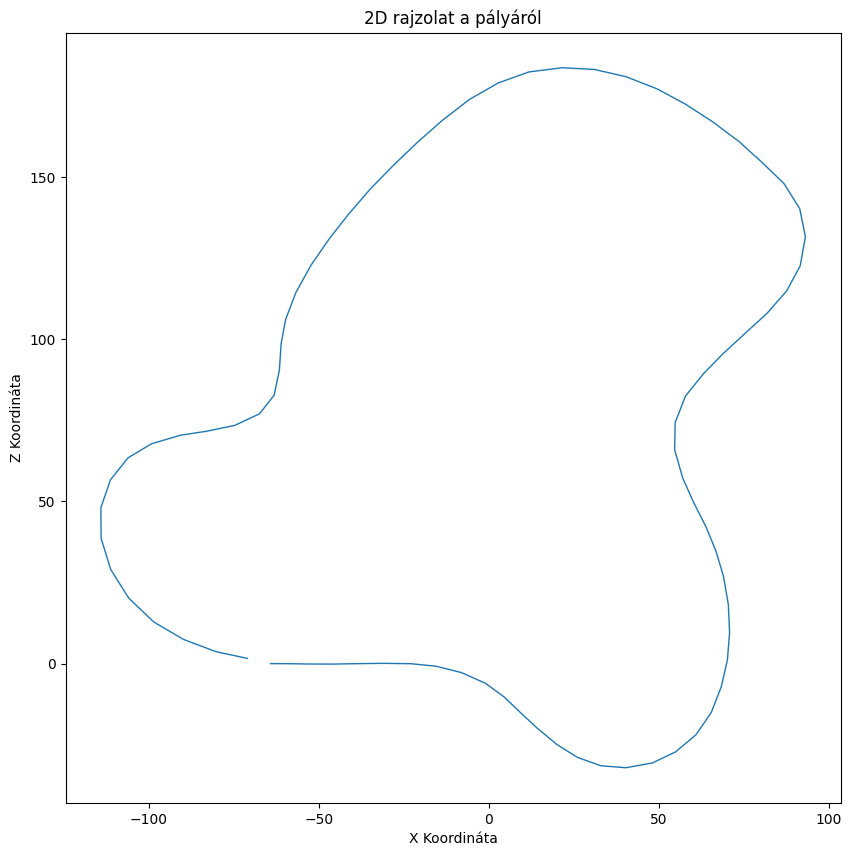

In [8]:


df = pd.read_csv("map_data.csv", skipfooter=1, header=None, engine='python')

x = df.iloc[:, 0]
y = df.iloc[:, 1]
z = df.iloc[:, 2]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(x, z, lw=1)  
ax.set_xlabel("X Koordináta")
ax.set_ylabel("Z Koordináta")
ax.set_title("2D rajzolat a pályáról")
plt.show()

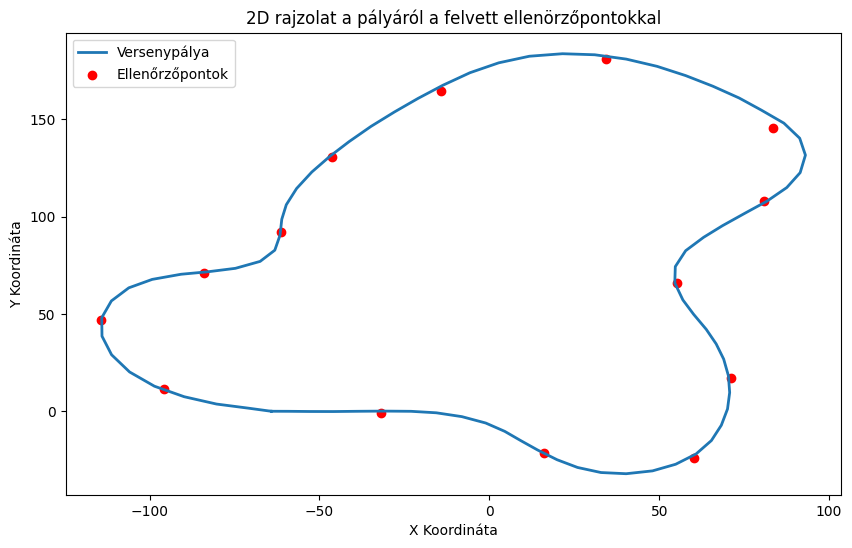

In [9]:


df = pd.read_csv("map_data.csv", skipfooter=1, header=None, engine='python')
df2 = pd.read_csv("checkpoints.csv", skipfooter=1, header=None, engine='python')

x = df.iloc[:, 0]
y = df.iloc[:, 2]
a = df2.iloc[:, 0]
b = df2.iloc[:, 2]

x = pd.concat([x, pd.Series(x.iloc[0])])
y = pd.concat([y, pd.Series(y.iloc[0])])

plt.figure(figsize=(10, 6))
plt.plot(x, y, lw=2, label="Versenypálya")  
plt.scatter(a, b, c='red', marker='o', label="Ellenőrzőpontok") 
plt.xlabel("X Koordináta")
plt.ylabel("Y Koordináta")
plt.title("2D rajzolat a pályáról a felvett ellenörzőpontokkal")
plt.legend() 


plt.show()

## Creating the environment 

In [10]:
g29controller = LogitechG29Data()

In [11]:
controller_data = None  
def read_controller_data(controller):
    while True:
        global controller_data  
        data = controller.read()
        controller_data = data 
        return controller_data
    
  
      

In [12]:
pyvjoy.VJoyDevice(1)

In [13]:
class Assetto_Corsa_Reinforcement_Learning(Env):
    
    
    def __init__(self):
        
        #Initialize the observation and the action spaces
        self.observation_space = spaces.Box(low=0, high=255, shape=(72,128,1), dtype=np.uint8)        
        self.action_space = spaces.Box(
        low=np.array([0.0, 0.0, 0.0]),
        high=np.array([1.0, 1.0, 1.0]),
        dtype=np.float32
        )
        
        #Initialize the virtual controller
        self.j = pyvjoy.VJoyDevice(1)
        self.vjoy_const = 32767

        # Initialize vjoy state
        self.j.data.wAxisX = 32767//2 #steer
        self.j.data.wAxisY = 0 #brake
        self.j.data.wAxisZ = 0 #throttle
        self.j.update()
        
        
        #Initialize the map and checkpoints data
        self.map_data = pd.read_csv('map_data.csv', skipfooter=1)
        self.checkpoints_data = pd.read_csv('checkpoints.csv', skipfooter=1)
        self.current_checkpoint = 0
        self.checkpoints = list(zip(self.checkpoints_data.iloc[:, 0], self.checkpoints_data.iloc[:, 2]))
        self.centerpoints = list(zip(self.map_data.iloc[:, 0], self.map_data.iloc[:, 2]))
        self.map_data_points = self.centerpoints
        self.center_line = self.calculate_center_line(self.map_data_points)
        self.distance_to_center_line = 0
        self.distance_to_checkpoint = 0
        
        
        self.episode_start_time = time()
        
        #Initialize the filter for the input controls
        self.filter = 0.4
        self.filtered_throttle = 0.0
        self.filtered_brake = 1.0
        self.filtered_steer = 0.5
       
        
        #Initialize the all reward to count the overall rewards for an episode
        self.allreward = 0
   
        #Initialization to decide if its human or machine controlled 
        #self.human_control = True
        
       
        #initialization for the telemetry data
        self.speed = 0
        self.steer_angle = 0
        self.rpm = 0
        self.gear = 0
        self.throttle = 0
        self.brake = 0
        self.offset = 0
        self.tyres_out = 0
        self.carx = 0
        self.cary = 0
        self.carz = 0
        self.data_collector = DataCollector('Assetto corsa')
        self.start_distance = self.data_collector.sample()[12]
        self.distance_taken= 0
        self.time_received = time()
        self.last_received = self.time_received
        self.image_array = np.zeros((72,128,1))
        
        self.last_obs = self.image_array
        
        
        
    def interpolate_points_between(self, x1, y1, x2, y2):
        num_points = max(int(max(abs(x2 - x1), abs(y2 - y1))), 1)

        x_increment = (x2 - x1) / num_points
        y_increment = (y2 - y1) / num_points

        interpolated_points = []

        for i in range(num_points):
            interpolated_x = x1 + i * x_increment
            interpolated_y = y1 + i * y_increment
            interpolated_points.append((interpolated_x, interpolated_y))

        return interpolated_points

    def calculate_center_line(self, map_data_points):
        center_line = []
        for i in range(len(map_data_points) - 1):
            x1, z1 = map_data_points[i]
            x2, z2 = map_data_points[i + 1]
            interpolated_points = self.interpolate_points_between(x1, z1, x2, z2)
            center_line.extend(interpolated_points)
        return center_line

       
    def get_human_input(self):
        data = read_controller_data(g29controller)
        if data[0]< 0.13:
            data[0]== 0.13
        if data[0]> 0.87:
            data[0]==0.87
            
        if data[1]<=0:
            data[1] == 0;
        if data[1] >= 92:
            data[1]==0
            
        if data[2]<=0:
            data[2] == 0;
        if data[2] >= 0.92:
            data[2]==0
        
        return data
   
    def filter_input(self, inputs):
        
        self.filtered_throttle += self.filter * (inputs[2] - self.filtered_throttle)
        self.filtered_brake += self.filter * (inputs[1] - self.filtered_brake)
        self.filtered_steer += self.filter  * (inputs[0] - self.filtered_steer)

        return [self.filtered_steer, self.filtered_brake, self.filtered_throttle]

    def vjoy_controls(self, inputs):
        self.inputs=inputs
        steering = int(inputs[0] * self.vjoy_const)
        brakes = int(inputs[1] * self.vjoy_const)
        throttle = int(inputs[2] * self.vjoy_const)

        self.j.data.wAxisX = steering
        self.j.data.wAxisY = throttle
        self.j.data.wAxisZ = brakes

        self.j.update()

    def vjoy_reset(self, inputs):
        self.default = [0.5, 1.0, 0.0]
        self.vjoy_controls(self.default)
    
    def observe(self) -> Tuple[np.ndarray, float, bool, Dict[str, Any]]:           
        data=[]
        new_data = self.data_collector.sample()
        data.append(new_data)
        
        telemetry_data = new_data
        self.speed = telemetry_data[0] 
        self.tyres_out = telemetry_data[1]
        self.wheelSlipRL = telemetry_data[2]
        self.wheelSlipRR = telemetry_data[3]
        self.gear = telemetry_data[4] 
        self.rpm = telemetry_data[5]
        self.steer_angle = telemetry_data[6]
        self.carDamagefront = telemetry_data[7]
        self.carDamagerear = telemetry_data[8]
        self.carDamageleft = telemetry_data[9]
        self.carDamageright = telemetry_data[10]
        self.carDamagecentre = telemetry_data[11]
        self.distancetraveled = telemetry_data[12]
        self.currentSectorIndex = telemetry_data[13]
        self.completedLaps = telemetry_data[14]
        self.throttle = telemetry_data[15]
        self.brake = telemetry_data[16]
        self.carx = telemetry_data[17]
        self.cary = telemetry_data[18]
        self.carz = telemetry_data[19]
        self.maxRpm = telemetry_data[20]
        self.image_array = telemetry_data[21]
     
        self.current_position = (self.carx, self.carz)
        distances_to_center_line = [np.linalg.norm(np.array(self.current_position) - np.array(point)) for point in self.center_line]
        self.distance_to_center_line = min(distances_to_center_line)
      
        self.last_received = self.time_received
        
        observation = self.image_array
        done = False
        
        if self.cary < 0:
            self.vjoy_controls([0.5,1.0,0.0])
            done = True
            cv2.destroyAllWindows()
            foregrnd("Assetto corsa")
            sleep(0.01)
            back_to_the_start('Assetto Corsa')
            sleep(0.01)
            foregrnd("Assetto corsa")
            env.reset()
            self.vjoy_controls([0.5,1.0,0.0])
        
        if self.tyres_out >=3:
            self.vjoy_controls([0.5,1.0,0.0])
            done = True
            self.vjoy_controls([0.5,1.0,0.0])
            cv2.destroyAllWindows()
            foregrnd("Assetto corsa")
            sleep(0.01)
            back_to_the_start('Assetto Corsa')
            sleep(0.01)
            foregrnd("Assetto corsa")
            env.reset()
            self.vjoy_controls([0.5,1.0,0.0])
            
        if done == True:
            self.filtered_throttle = 0.0
            self.filtered_brake = 0.0
            self.filtered_steer = 0.5
            self.vjoy_controls([0.5,1.0,0.0])
            back_to_the_start('Assetto corsa')
            self.vjoy_controls([0.5,1.0,0.0])
            cv2.destroyAllWindows()
            
        reward = self.calculate_reward(done)
        
        self.allreward += reward
        

        info = {
            "pos": (self.carx, self.carz),
            "distance_to_center_line": self.distance_to_center_line,
            "speed": self.speed,
            "tyres_out": self.tyres_out,
            "current_gear": self.gear,
            "brake": self.brake,
            "throttle": self.throttle,
            "steer": self.steer_angle,
            "rpm": self.rpm
        }
        current_distance = self.distancetraveled - self.start_distance
        self.distance_taken = current_distance
        episode_duration = time() - self.episode_start_time
        
        img=np.zeros((300,360, 3), dtype=np.uint8)
        distance_taken = f"dist_taken: {current_distance}"
        runtime = f"ep_duration: {episode_duration}"
        rew = f"reward: {reward}"
        allrew = f"allreward: {self.allreward}"
        x=f"X: {self.carx}"
        y=f"Y: {self.cary}"
        z=f"Z: {self.carz}"
        distance_to_checkpoint = f"d_cp: {self.distance_to_checkpoint}"
        distance_to_center_line = f"d_center: {self.distance_to_center_line}"
        
        cv2.putText(img, rew, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, allrew, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, distance_to_center_line, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, distance_to_checkpoint, (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, runtime, (10,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, x, (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, y, (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, z, (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
        cv2.putText(img, distance_taken, (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)

        cv2.imshow('monitor_data', img)
        cv2.waitKey(1)

        return observation, reward, done, info
    
    def calculate_reward(self, done: bool) -> float:
        desired_distance = 500  
        distance_reward = self.distance_taken / desired_distance
       # max_steer_angle = 0.1
       # steering_offset = 0.5 - abs(normalized_steer)
       # self.steering_reward = (abs(steering_offset) * max_steer_angle)
               
        #print(steering_reward)
               
        #print(steering_offset)
        
        min_speed = 25 
        max_speed = 70  
        speed_reward = 0.1 if min_speed <= self.speed <= max_speed else -0.1
        
        max_distance_to_center_line = 5
        
        if done: 
            return -0.8
            
        if self.distance_to_center_line > max_distance_to_center_line:
            return -0.8
        
        if self.tyres_out >=2:
            return -0.8
        
        #self.prev_steer= normalized_steer
        
        if self.speed > 30:
            return (1.0-(self.distance_to_center_line / max_distance_to_center_line)) * ((self.speed/max_speed)*1.2) + speed_reward + (distance_reward * 2)
        if self.speed <= 30:
        
            return -0.1 +((self.speed/30)/8)
    
    def step(self, action):
        
        self.vjoy_controls(action)
        observation, reward, done, info = self.observe()

        return observation, reward, done, info
    def reset(self) -> None:
        self.time_received = time()
        self.last_received = self.time_received
        self.image_array = np.zeros((360,640,1))        
        self.distance_to_checkpoint = 0    
        self.allreward = 0
        self.episode_start_time = time()
        self.speed = 0
        self.steer_angle = 0
        self.rpm = 0
        self.gear = 1
        self.throttle = 0
        self.brake = 0
        self.offset = 0
        self.tyres_out = 0
        self.current_checkpoint = 0
        cv2.destroyAllWindows()
        foregrnd("Assetto corsa") 
        sleep(0.05)
        back_to_the_start('Assetto corsa')
        self.start_distance= self.data_collector.sample()[12]
        sleep(0.02)
        self.vjoy_controls([0.5,1.0,0.0])
        foregrnd("Assetto corsa") 
        foregrnd("Assetto corsa") 
        sleep(0.3)
        self.vjoy_controls([0.5,1.0,0.0])
        initial_observation = np.zeros((72, 128, 1), dtype=np.uint8) 
        
        return initial_observation

        
       

In [14]:
env=Assetto_Corsa_Reinforcement_Learning()

c:\python37\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\python37\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [17]:
cv2.destroyAllWindows()

# Train

In [18]:
from stable_baselines3.common.policies import ActorCriticPolicy
class CustomPolicy(ActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
            net_arch=dict(pi=[256, 256, 128, 64], vf=[256, 256, 128, 64]))

# Create the custom environment
env = Assetto_Corsa_Reinforcement_Learning()

# Create and train a PPO agent with the custom policy
tb_log_dir = "./presentation/"
model = PPO(CustomPolicy, env, verbose=1, tensorboard_log=tb_log_dir)
custom_policy = model.policy

model.learn(total_timesteps=10000)

# Save the policy object separately
custom_policy.save("presentation")
model.save("presentation")



c:\python37\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
c:\python37\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
c:\python37\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./presentation/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 268      |
|    ep_rew_mean     | -46.3    |
| time/              |          |
|    fps             | 15       |
|    iterations      | 1        |
|    time_elapsed    | 135      |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 288         |
|    ep_rew_mean          | -52.7       |
| time/                   |             |
|    fps                  | 14          |
|    iterations           | 2           |
|    time_elapsed         | 285         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004664761 |
|    clip_fraction        | 0.0

RuntimeError: File presentation cannot be opened.

In [ ]:
cv2.destroyAllWindows()

# Evaluate

In [19]:


loaded_model = PPO.load("best_assetto_rl_model")
env = Assetto_Corsa_Reinforcement_Learning()
eval_episodes = 20  
all_rewards = []

for _ in range(eval_episodes):
    
    obs = env.reset()
    episode_rewards = 0
    done = False
    while not done:
        action, _ = loaded_model.predict(obs, deterministic=True)
        obs, reward, done, _ = env.step(action)
        episode_rewards += reward
    all_rewards.append(episode_rewards)

mean_reward = np.mean(all_rewards)
std_reward = np.std(all_rewards)


print(f"Átlag eredmény a {eval_episodes} epizód során: {mean_reward:.2f} +/- {std_reward:.2f}")

Átlag eredmény a 20 epizód során: 694.26 +/- 175.00


In [ ]:
os.system(f"tensorboard --logdir={tb_log_dir}")  #open tensorboard, but better to write it into the terminal -> tensorboard --logdir=./<folder_name>

# Retrain

In [ ]:


class CustomPolicy(ActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                          net_arch=dict(pi=[256, 256, 128, 64], vf=[256, 256, 128, 64]))

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
   
        ep_len_mean = [info['l'] for info in self.model.ep_info_buffer] 
        ep_rew_mean = [info['r'] for info in self.model.ep_info_buffer] 

        self.logger.record('ep_len_mean', np.mean(ep_len_mean) if ep_len_mean else 0)
        self.logger.record('ep_rew_mean', np.mean(ep_rew_mean) if ep_rew_mean else 0)
        self.logger.record('fps', int(1 / self.num_timesteps))
        self.logger.record('iterations', self.num_timesteps // self.model.n_steps)
        
      
        if hasattr(self.model.env, 'dt'):
            self.logger.record('time_elapsed', int(self.model.num_timesteps * self.model.env.dt))
        else:
            self.logger.record('time_elapsed', 0)  

        self.logger.record('total_timesteps', self.model.num_timesteps)

      
        if 'rollout_buffer' in locals() and locals()['rollout_buffer'].full:
            for key, value in self.model.train().items():
                self.logger.record(f'train/{key}', value)

            self.logger.record('loss/approx_kl', np.mean(self.model.policy_losses[0].numpy()))
            self.logger.record('loss/clip_fraction', np.mean((self.model.clipfrac * 100).numpy()))
            self.logger.record('loss/clip_range', np.mean(self.model.clip_range.numpy()))
            self.logger.record('loss/entropy_loss', np.mean(self.model.entropy_losses.numpy()))
            self.logger.record('loss/explained_variance', np.mean(self.model.explained_var.numpy()))
            self.logger.record('loss/learning_rate', np.mean(self.model.lr_schedule().numpy()))
            self.logger.record('loss/policy_gradient_loss', np.mean(self.model.policy_gradient_losses.numpy()))
            self.logger.record('loss/std', np.mean(self.model.policy.std.numpy()))
            self.logger.record('loss/value_loss', np.mean(self.model.value_losses.numpy()))

        return True

env = Assetto_Corsa_Reinforcement_Learning()

tb_log_dir = "./finishlogs_end/"

loaded_model = PPO.load("best_assetto_rl_model", env=env, verbose=1, tensorboard_log=tb_log_dir)

custom_policy = loaded_model.policy

custom_callback = CustomCallback()


loaded_model.learn(total_timesteps=100000, callback=custom_callback)

cv2.destroyAllWindows()